# Hegselmann Krause - Stability Tests

## Motivation

The model of Hegselmann and Krause does not seem to represent a stable system regarding the number of clusters that form when the model reaches an equilibrium as a measure of stability. 

## Experiment Description
This experiment is designed to test if very small perturbations during the opinion formation process change the number of clusters that are formed when the nodes act based on the bounded confidence model of Hegselmann and Krause. 
We create those small perturbations by randomly choosing p unique rounds (where p is strictly less than the convergence time of the model). In each of these p rounds, all nodes have their confidence interval doubled. Nodes use the normal confidence interval on all the other rounds.

### First Experiment - Single Runs
The first phase of the experiment involves single runs of the model for 64 nodes and the same initial opinions. We set p=1 and test the behaviour of the model for multiple values of ε (the confidence interval). We see that for ε < 0.2 the model with and without the perturbation changes behaviour regarding the final number of clusters that are created. In most cases the anomally causes the number of clusters to reduce by there is one run where the number of clusters increased due to our changes to the behaviour of the model.

### Second Experiment - Average Behaviour
The exact change in the behaviour of the model that is caused by the random perturbation depends heavily on the initial opinions. To get a better sense for the effect that our change has on the model, we set p=3 and run the model for N=625, ε in the interval [0.02, 0.4]. We repeat each run for 100 random initial opinion vectors. The results indicate that there is a small but not insignificant change in the behaviour of the model.

In [ ]:
%matplotlib inline
from __future__ import division, print_function

import numpy as np
from numpy import diag
import numpy.random as rand
from numpy.linalg import norm, inv, eigvals
import random as stdrand

import sys
from IPython import display
from tqdm import tqdm
from ipyparallel import Client

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from itertools import chain, repeat
import pandas as pd

import models
from util import *
from viz import *
import networkx as nx
import time

from IPython.display import clear_output
from tqdm import trange

sns.set_context('paper', font_scale=1.5)

In [46]:
def run_both(N, op_eps, special_num=1):
    s = rand.rand(N)
    max_rounds = 12
    op1 = models.hk(s, op_eps, max_rounds, conv_stop=False)
    op2, special_rounds = models.hk_perturbation(s, op_eps, max_rounds, p_points=special_num, p_max=6, conv_stop=False)
    return op1, op2, special_rounds


def plot_comparison(op1, op2, special_rounds, op_eps):
    
    print('[+] HK Original Clusters = {}'.format(cluster_count(op1[-1], op_eps)))
    print('[+] HK Stability Clusters = {}'.format(cluster_count(op2[-1], op_eps)))
    ax1 = plt.subplot(2, 1, 1)
    plot_opinions(op1, dcolor=True, cmap=plt.cm.gist_rainbow, linewidth=1.5)
    ax1.get_xaxis().set_visible(False)
    plt.vlines(special_rounds, 0.0, 1.0)

    ax2 = plt.subplot(2, 1, 2, sharex=ax1)
    plot_opinions(op2, dcolor=True, cmap=plt.cm.gist_rainbow, linewidth=1.5)
    plt.vlines(special_rounds, 0.0, 1.0)
    

def plot_comparison2(op1, op2, special_rounds, op_eps):
    
    c1 = sns.xkcd_rgb['denim blue']
    c2 = sns.xkcd_rgb['pale orange']
    print('[+] HK Original Clusters = {}'.format(cluster_count(op1[-1], op_eps)))
    print('[+] HK Stability Clusters = {}'.format(cluster_count(op2[-1], op_eps)))
    N = op1.shape[1]
    for i in xrange(N):
        plt.plot(op1[:, i], c1, alpha=0.7, linewidth=2)
    for i in xrange(N):
        plt.plot(op2[:, i], c2, alpha=0.7, linewidth=3)
    plt.vlines(special_rounds, 0.0, 1.0, linewidth=5)
    p1 = patches.Patch(color=c1, label='Original HK')
    p2 = patches.Patch(color=c2, label='Perturbation')
    legend = plt.legend(handles=[p1, p2], shadow=True, frameon=True)
    legend.get_frame().set_facecolor('#FFFFFF')
    plt.xlabel('round')
    plt.ylabel('opinion')
    plt.show()

In [4]:
N = 64

# Procedure

- Run the HK normally
- Run the HK but choose **one** special round where all nodes can see at distance 2*ε
- Compare the behaviour of the opinions over time
- Compare the final number of clusters

# The results of the experiment can be found below for various ε
- ε is the op_eps variable on the first line of each experiment
- The black vertical line is the *special* round which is different between the original and the modified HK


[+] HK Original Clusters = 8
[+] HK Stability Clusters = 6


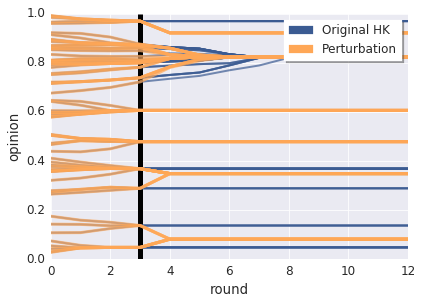

In [47]:
rand.seed(1518)
stdrand.seed(19)
op_eps = 0.05

op1, op2, special_rounds = run_both(N, op_eps)
plot_comparison2(op1, op2, special_rounds, op_eps)
plt.show()

[+] HK Original Clusters = 4
[+] HK Stability Clusters = 3


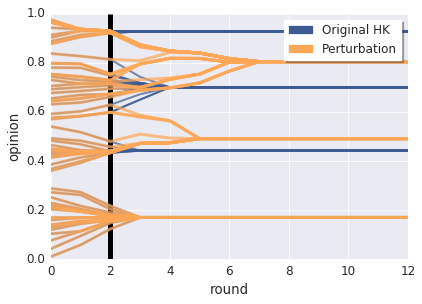

In [48]:
rand.seed(746288)
stdrand.seed(123141)
op_eps = 0.1

op1, op2, special_rounds = run_both(N, op_eps)
plot_comparison2(op1, op2, special_rounds, op_eps)
plt.show()

[+] HK Original Clusters = 3
[+] HK Stability Clusters = 2


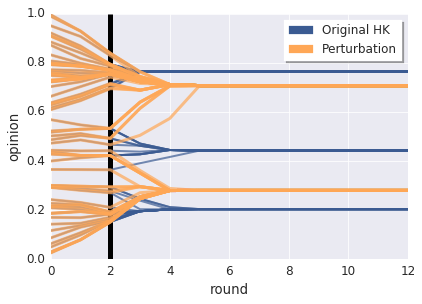

In [49]:
rand.seed(44124)
stdrand.seed(123141)
op_eps = 0.15

op1, op2, special_rounds = run_both(N, op_eps)
plot_comparison2(op1, op2, special_rounds, op_eps)
plt.show()

[+] HK Original Clusters = 2
[+] HK Stability Clusters = 2


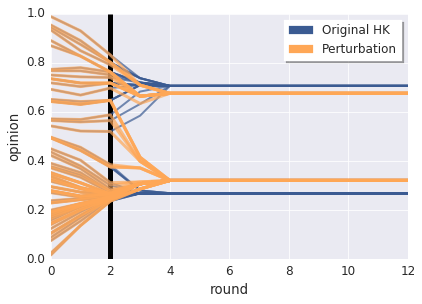

In [50]:
rand.seed(4223)
stdrand.seed(123141)
op_eps = 0.2

op1, op2, special_rounds = run_both(N, op_eps)
plot_comparison2(op1, op2, special_rounds, op_eps)
plt.show()

[+] HK Original Clusters = 2
[+] HK Stability Clusters = 1


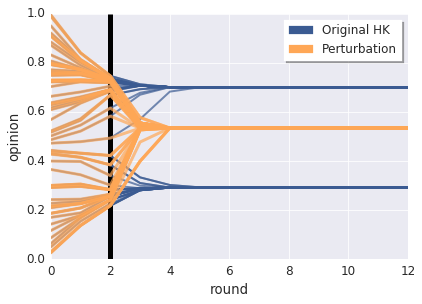

In [51]:
rand.seed(44124)
stdrand.seed(123141)
op_eps = 0.25

op1, op2, special_rounds = run_both(N, op_eps)
plot_comparison2(op1, op2, special_rounds, op_eps)
plt.show()

# A more in-depth look

- Repeat over many initial opinions
- Take 2 perturbation points
- Count the difference in number of clusters
- Calculate the percentage of change (by dividing by the initial number of clusters)

In [73]:
rand.seed(49414512)
stdrand.seed(123154)

N = 625
s = rand.rand(N)
s_list = [rand.rand(N) for _ in xrange(100)]
max_rounds = 1e3
eps_list = np.linspace(0.01, 0.3, 10)

In [74]:
def run_model(s):
    import models
    from util import cluster_count
    import numpy as np
    op1 = models.hk(s, op_eps, max_rounds)
    conv_time = op1.shape[0]
    op2, _ = models.hk_perturbation(s, op_eps, max_rounds, p_points=3, p_max=max(4, conv_time//2))
    clusters1 = cluster_count(op1[-1], op_eps)
    clusters2 = cluster_count(op2[-1], op_eps)
    abs_diff = np.abs(clusters1-clusters2)
    
    return clusters2, clusters1

In [75]:
v, dv = parallel_init('/home/user/opinions-research/', profile='ssh')

[*] 15 parallel engines available
[*] Finished setting working directories


In [76]:
result = np.empty((0, 3))
dv.clear()
for op_eps in tqdm(eps_list):
    ar = dv.push(dict(op_eps=op_eps, max_rounds=max_rounds))
    ar.get()
    cluster_diffs = parallel_map(v, run_model, s_list, silent=True)
    for t in cluster_diffs:
        result = np.vstack((result, np.array([op_eps, t[0], t[1]])))


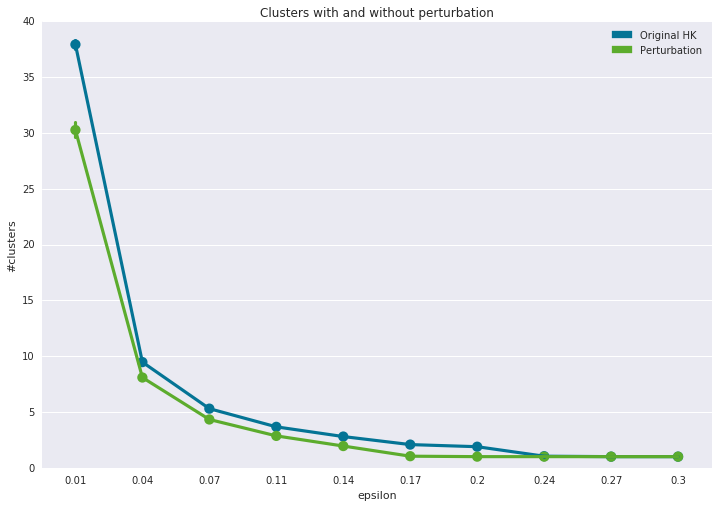

In [84]:
c1 = sns.xkcd_rgb['sea blue']
c2 = sns.xkcd_rgb['grass']
result = np.round(result, decimals=2)
df = pd.DataFrame(data=result, columns=['eps', 'clusters2', 'clusters1'])
cdiff = sns.pointplot(x='eps', y='clusters1', data=df, color=c1)
cnum = sns.pointplot(x='eps', y='clusters2', data=df, color=c2)
plt.ylabel('#clusters')
plt.xlabel('epsilon')
plt.title('Clusters with and without perturbation')
fig = plt.gcf()
fig.set_size_inches(12, 8)
p1 = patches.Patch(color=c1, label='Original HK')
p2 = patches.Patch(color=c2, label='Perturbation')
plt.legend(handles=[p1, p2])
plt.ylim(0, 40)
plt.show()